In [18]:
# The hardest part of a Trading Strategy/Machine Learning is minimizing Overfitting. 

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score # pip install scikit-learn
import yfinance_fix

In [19]:
TICKER = "SPY"
INTERVAL = "1d"
PERIOD = "730d" if INTERVAL == "1h" else "max"
MACD_FAST = 12 # MACD
MACD_SLOW = 27
MACD_SPAN = 9
MFI_LENGTH = 14 # MFI
OVERBROUGHT = 70
OVERSOLD = 30 
BB_LENGTH = 20 # BB
STD_DEV = 2
RSI_LENGTH = 14 # RSI
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30
STRATEGY = ['Volume_Change', 'Close_Change' , 'High_Change', 'Low_Change', 'Open_Change', "MACD_HIST", "MFI", "BB", "RSI"]
SHIFT_RANGE = range(1, 120)
SHIFT = 1
OPTIMAL_SHIFT = None
LOOKBACK = 10000
TRAIN_SIZE = .7 # Train Test Split

# --- (1) Daten herunterladen ---
def get_data(ticker=TICKER, interval=INTERVAL, lookback=LOOKBACK):
    df = yf.download(ticker, session=yfinance_fix.chrome_session, interval = interval, period = PERIOD)

    if df.empty:
        print(f"WARNUNG: Keine Daten für {ticker} erhalten!")
        return df # Gibt leeren DF zurück, damit main() das abfangen kann
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    for c in df.columns:
        df[f"{c}_Change"] = df[f"{c}"].pct_change() * 100

    subset = df.iloc[-lookback:,:]

    plt.figure()
    plt.plot(subset["Close"])
    plt.title(f"Price Movements for {ticker} during Study")
    
    return df.iloc[-lookback:, :].dropna()

# --- (2) Unabhängige Variablen ("Features") definieren ---

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    return df

def add_MFI(df, length = MFI_LENGTH):
    df["Average_Price"] = (df["High"]+df["Low"]+df["Close"])/3
    df["Money_Flow"] = df["Volume"]*df["Average_Price"]
    df["Pos_Flow"] = np.where(df["Average_Price"].diff()>0, df["Average_Price"], 0)
    df["Neg_Flow"] = np.where(df["Average_Price"].diff()<0, df["Average_Price"], 0)
    df["MFR"] = df["Pos_Flow"].rolling(window=length).sum() / df["Neg_Flow"].rolling(window=length).sum()
    df["MFI"] = (100 - 100 / (1 + df["MFR"]))

    return df.dropna()

def add_BB(df, std_dev = STD_DEV, length = BB_LENGTH):
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
    df["BB_STD"] = df["Close"].rolling(window=length).std()
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])
    df["BB"] = ((df["Close"] - df["Lower Band"])/(df["Upper Band"] - df["Lower Band"]))

    return df.dropna()

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):
    price_change = df["Close"].diff()
    df["gain"] = price_change.where(price_change > 0, 0)
    df["loss"] = - price_change.where(price_change < 0, 0)
    df["avg_gain"] = df["gain"].rolling(window = length).mean()
    df["avg_loss"] = df["loss"].rolling(window = length).mean()
    rs = df["avg_gain"] / df["avg_loss"]
    df["RSI"] = 100 - (100/(1+rs))

    return df.dropna()


# --- (3) Add Target ---
def add_target(df, shift=SHIFT):
    df = df.copy()
    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1
    return df.dropna().reset_index(drop=True)

# --- (4) Generate Logistic Regression Output ---
def generate_regression_output(df, features=STRATEGY, target="Target"):
    subset = df[features + [target]].replace([np.inf, -np.inf], np.nan).dropna()

    if len(subset) < 10:
        raise ValueError("Too few rows after cleaning.")

    subset = subset.sample(frac=1, random_state=42).reset_index(drop=True)

    X = sm.add_constant(subset[features])
    y = subset[target]
    
    model = sm.Logit(y, X).fit(disp=0)
    y_pred_prob = model.predict(X)

    df = df.loc[subset.index]
    df["Prediction"] = (y_pred_prob > 0.5).astype(int)

    return df, y, y_pred_prob

# --- (5) Analyze Logistic Regression Output ---
def add_confusion_matrix(df):
    cm = confusion_matrix(df["Target"], df["Prediction"])
    labels = ["Down (0)", "Up (1)"]
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure()
    sns.heatmap(cm_df, annot = True, cmap = "Blues")
    plt.title("(3) Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

# Area Under the Curve Plot - ROC: Receiver Operating Characteristic Plot for Logistic Regression
def add_roc_plot(y_true, y_scores, title=f"ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_pred_prob):
    plt.figure()
    plt.hist(y_pred_prob, bins=50, color="grey")
    plt.title("Distribution of Logistic Predictions")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# --- (6) Optimize for AUC (With Shift Range) ---
def explore_shift_auc(df_raw):
    print(f" Exploring AUC over SHIFT range for {TICKER} on {INTERVAL} interval\n")
    results = []

    for shift in SHIFT_RANGE:
        try:
            df = add_target(df_raw.copy(), shift)
            df, y, y_pred_prob = generate_regression_output(df)
            auc_score = roc_auc_score(y, y_pred_prob)
            print(f"Shift: {shift:2d} | AUC {auc_score:.4f}")
            results.append({"Shift": shift, "AUC": auc_score})
        except Exception as e:
            print(f"Shift {shift}: skipped due to error ({e})")

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)
    return results_df

# --- (7) Add Train Test Split Function ---
def train_test_split(df, train_size=TRAIN_SIZE):
    # Once we have our weights and bias from the training set, we will use it on the testing set
    df = df.sample(frac=1).reset_index(drop=True)

    split = int((len(df) * .7))
    all_rows = int((len(df)))
    test_nr = int((len(df) * .3))
    print(f"Nr. of Rows (All): {all_rows}")
    print(f"Nr. of Training Rows: {split}")
    print(f"Nr. of Testing Rows: {test_nr}")

    train = df.iloc[:split, :]
    test = df.iloc[split:, :] # Our future data, not included in the training of the model
    
    return df, train, test 



[*********************100%***********************]  1 of 1 completed

Nr. of Rows (All): 8242
Nr. of Training Rows: 5769
Nr. of Testing Rows: 2472


Price,Close,High,Low,Open,Volume,Close_Change,High_Change,Low_Change,Open_Change,Volume_Change,...,Upper Band,Lower Band,BB,gain,loss,avg_gain,avg_loss,RSI,Close + 1,Target
0,437.935608,439.783111,435.230328,437.436027,86268800,1.226675,0.573414,0.865082,0.374200,-23.432053,...,445.508539,433.502453,0.369242,5.306946,-0.000000,0.993110,1.284642,43.600438,429.414490,0
1,24.581095,24.650386,24.546449,24.650386,68000,-0.210951,-0.210360,-0.281473,-0.140332,24.314442,...,25.121636,24.069997,0.486001,0.000000,0.051964,0.050733,0.066817,43.158630,24.633059,1
2,92.797234,93.468247,91.849920,92.086749,10272900,0.660964,1.043613,3.501130,3.218479,-59.873679,...,91.764476,82.666120,1.113510,0.609329,-0.000000,0.885794,0.382470,69.843044,92.323524,0
3,62.229496,62.244264,61.055212,61.660816,284646300,0.994818,-0.390057,1.898159,0.493465,-40.229326,...,64.267205,51.341571,0.842351,0.612972,-0.000000,0.924819,0.453255,67.109536,61.742077,0
4,81.667076,81.728131,81.334684,81.565322,47723300,0.133133,-0.700510,-0.266120,-0.816576,-17.893985,...,82.898626,78.874553,0.693954,0.108582,-0.000000,0.226287,0.118229,65.682523,80.452805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8237,87.463303,87.670400,85.868669,86.420926,73256700,1.758938,1.551305,0.024169,0.312546,64.084927,...,87.884014,86.062579,0.769022,1.511833,-0.000000,0.240271,0.195066,55.192046,87.877464,1
8238,101.813492,101.911923,101.511171,101.757244,49607000,0.138281,0.200446,0.326574,0.402340,-28.429834,...,101.844053,98.718261,0.990223,0.140594,-0.000000,0.234530,0.155688,60.102311,101.841637,1
8239,73.206520,73.612684,72.877718,72.929296,12810700,-0.026370,-0.061227,-0.247045,-0.457541,5.500379,...,76.054122,72.098883,0.280043,0.000000,0.019310,0.161176,0.348598,31.617134,73.406342,1
8240,80.202782,80.223036,79.676154,79.811185,43895100,0.584254,-0.668786,-0.025413,-1.071217,-15.662898,...,80.834121,78.941239,0.666467,0.465866,-0.000000,0.163488,0.153361,51.598073,80.486359,1


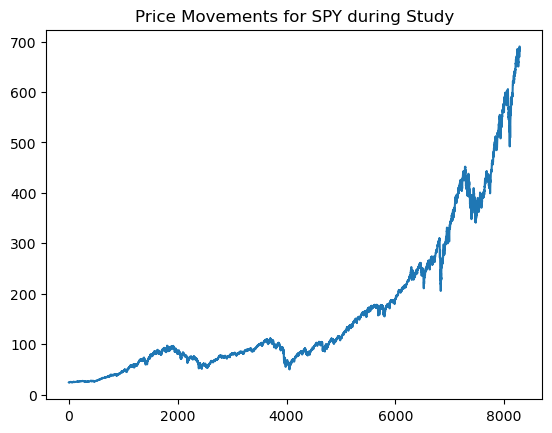

In [20]:
def make_dataset():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df, train, test = train_test_split(df)

    return df, train, test 

df, train, test = make_dataset()
df


 Exploring AUC over SHIFT range for SPY on 1d interval

Shift:  1 | AUC 0.5355
Shift:  2 | AUC 0.5377
Shift:  3 | AUC 0.5437
Shift:  4 | AUC 0.5432
Shift:  5 | AUC 0.5481
Shift:  6 | AUC 0.5481
Shift:  7 | AUC 0.5341
Shift:  8 | AUC 0.5502
Shift:  9 | AUC 0.5435
Shift: 10 | AUC 0.5396
Shift: 11 | AUC 0.5382
Shift: 12 | AUC 0.5418
Shift: 13 | AUC 0.5437
Shift: 14 | AUC 0.5343
Shift: 15 | AUC 0.5515
Shift: 16 | AUC 0.5487
Shift: 17 | AUC 0.5321
Shift: 18 | AUC 0.5484
Shift: 19 | AUC 0.5531
Shift: 20 | AUC 0.5462
Shift: 21 | AUC 0.5415
Shift: 22 | AUC 0.5414
Shift: 23 | AUC 0.5562
Shift: 24 | AUC 0.5383
Shift: 25 | AUC 0.5394
Shift: 26 | AUC 0.5430
Shift: 27 | AUC 0.5442
Shift: 28 | AUC 0.5371
Shift: 29 | AUC 0.5453
Shift: 30 | AUC 0.5493
Shift: 31 | AUC 0.5430
Shift: 32 | AUC 0.5454
Shift: 33 | AUC 0.5443
Shift: 34 | AUC 0.5434
Shift: 35 | AUC 0.5470
Shift: 36 | AUC 0.5347
Shift: 37 | AUC 0.5434
Shift: 38 | AUC 0.5559
Shift: 39 | AUC 0.5478
Shift: 40 | AUC 0.5360
Shift: 41 | AUC 0.5375
S

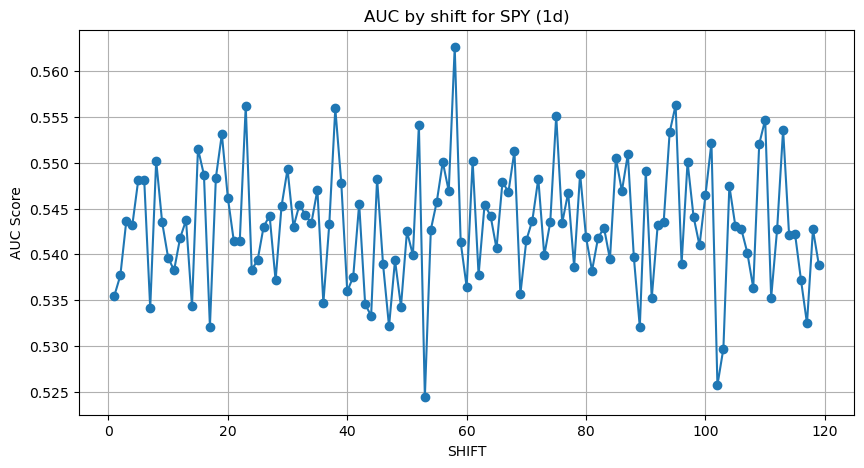


 Optimal SHIFT (Holding Period) based on AUC: 58

 Running Final Model Analysis with SHIFT = 58


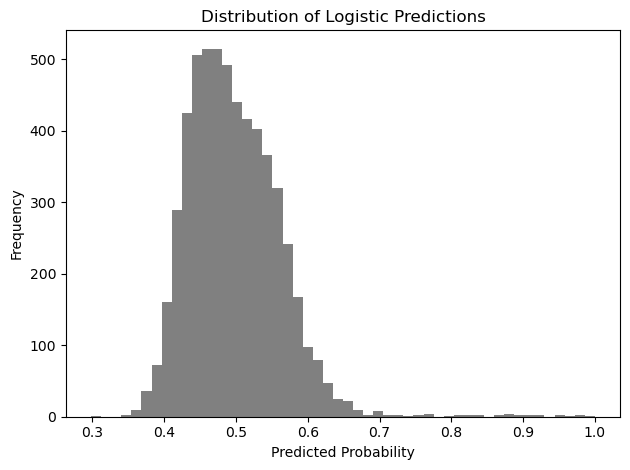

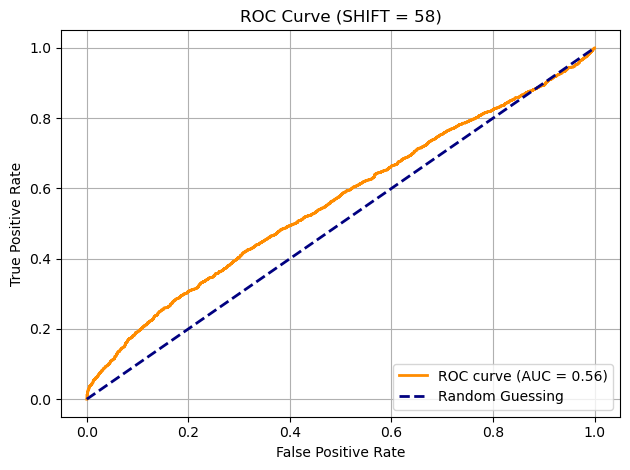

,Shift,AUC
0,58,0.562616
1,95,0.556287
2,23,0.556197
3,38,0.555943
4,75,0.555151
...,...,...
114,17,0.532104
115,89,0.532045
116,103,0.529703
117,102,0.525704


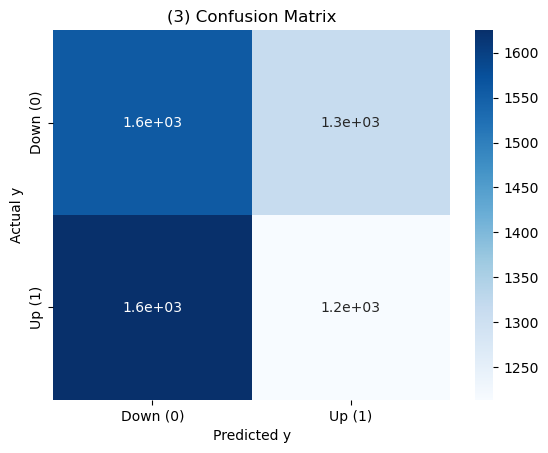

In [ ]:
# Applying the Regression Output Function only to the training Dataset

def train_dataset(df):
    global OPTIMAL_SHIFT

    # Explore AUC over multiple shifts
    results_df = explore_shift_auc(df)
    plot_df = results_df.sort_values(by="Shift")

    # Plot AUC vs. SHIFT 
    plt.figure(figsize=(10,5))
    plt.plot(plot_df["Shift"], plot_df["AUC"], marker="o")
    plt.title(f"AUC by shift for {TICKER} ({INTERVAL})")
    plt.xlabel("SHIFT")
    plt.ylabel("AUC Score")
    plt.grid(True)
    plt.show()

    # What this graphy could possibly guide us is:
    # I would place a trade on the minutely timeframe, I would want to hold my trade for {Optimal Shift} Min/Hour/Days
    # We want to find/see something closer to 0.60, becuase if our cutoff is 0.5, then we are just randomly seeing it 

    # Set optimal shift globally for future studies
    OPTIMAL_SHIFT = int(results_df.iloc[0]["Shift"])
    print(f"\n Optimal SHIFT (Holding Period to Maximize Returns) to optimize AUC: {OPTIMAL_SHIFT}")

    # Final Study with Optimal shift
    print(f"\n Running Final Model Analysis with SHIFT = {OPTIMAL_SHIFT}")
    df_final = add_target(df.copy(), shift=OPTIMAL_SHIFT)
    df_final, y_final, y_pred_prob = generate_regression_output(df_final)

    plot_prediction_distribution(y_pred_prob)
    add_roc_plot(y_final, y_pred_prob, title=f"ROC Curve (SHIFT = {OPTIMAL_SHIFT})")
    add_confusion_matrix(df_final)

    return df, results_df 

df, results_df = train_dataset(train)
results_df 

 Exploring AUC over SHIFT range for SPY on 1d interval

Shift:  1 | AUC 0.5219
Shift:  2 | AUC 0.5162
Shift:  3 | AUC 0.5360
Shift:  4 | AUC 0.5387
Shift:  5 | AUC 0.5412
Shift:  6 | AUC 0.5523
Shift:  7 | AUC 0.5511
Shift:  8 | AUC 0.5462
Shift:  9 | AUC 0.5306
Shift: 10 | AUC 0.5531
Shift: 11 | AUC 0.5422
Shift: 12 | AUC 0.5347
Shift: 13 | AUC 0.5381
Shift: 14 | AUC 0.5419
Shift: 15 | AUC 0.5502
Shift: 16 | AUC 0.5620
Shift: 17 | AUC 0.5302
Shift: 18 | AUC 0.5333
Shift: 19 | AUC 0.5403
Shift: 20 | AUC 0.5374
Shift: 21 | AUC 0.5595
Shift: 22 | AUC 0.5462
Shift: 23 | AUC 0.5379
Shift: 24 | AUC 0.5419
Shift: 25 | AUC 0.5296
Shift: 26 | AUC 0.5459
Shift: 27 | AUC 0.5344
Shift: 28 | AUC 0.5316
Shift: 29 | AUC 0.5386
Shift: 30 | AUC 0.5544
Shift: 31 | AUC 0.5383
Shift: 32 | AUC 0.5578
Shift: 33 | AUC 0.5315
Shift: 34 | AUC 0.5508
Shift: 35 | AUC 0.5448
Shift: 36 | AUC 0.5376
Shift: 37 | AUC 0.5348
Shift: 38 | AUC 0.5354
Shift: 39 | AUC 0.5408
Shift: 40 | AUC 0.5335
Shift: 41 | AUC 0.5344
S

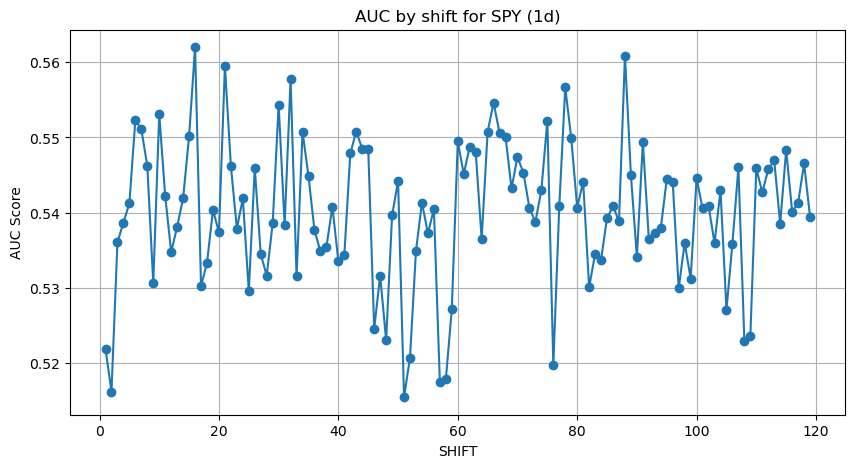


 Optimal SHIFT (Holding Period) based on AUC: 16

 Running Final Model Analysis with SHIFT = 16


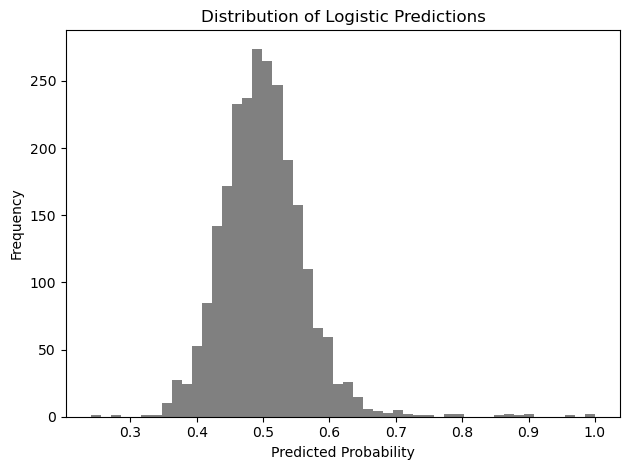

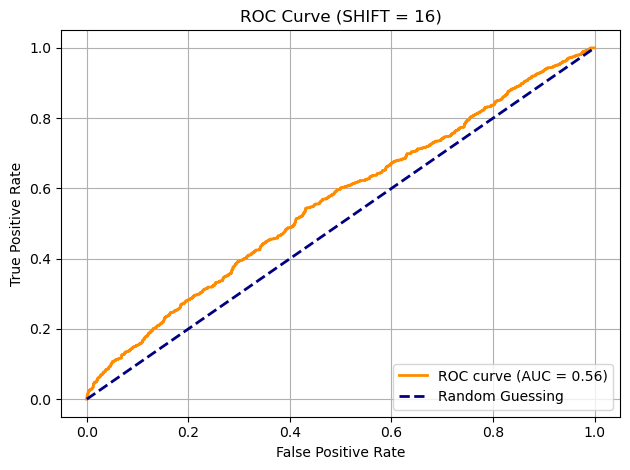

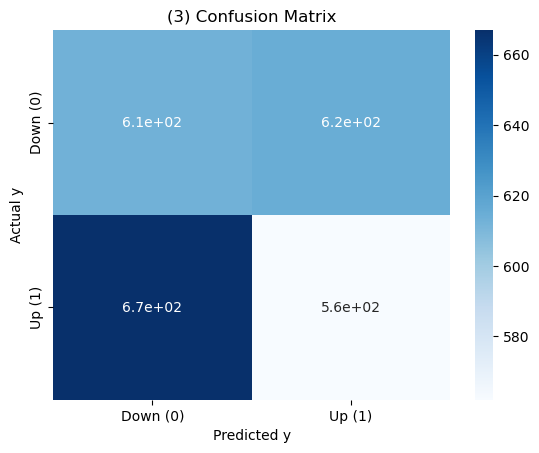

In [22]:
df, results_df = train_dataset(test)